# Model training

#### BTC-USDT for ROR_n24 with price action features


<br>

#### Performance by Model ID

```
model_id: 7764ba619949bad96eae8f48cc4f0cc673af7bee
    - n_estimates = 100
    - max_depth = 10
    - Mean Absolute Error:	 0.02534
    - Mean Absolute Outcome:	 0.02999
    - Mean Absolute Percent Error:	 0.84501
    - Error Variance:	 0.00142
    - R-Squared:		 0.27244

```


```
model_id: 286c8f533ecdc2563101afbcb5b49e33c1103266
    - max_depth=20
    - Mean Absolute Error:	 0.02554
    - Mean Absolute Outcome:	 0.02999
    - Mean Absolute Percent Error:	 0.85149
    - Error Variance:	 0.00147
    - R-Squared:		 0.24567
```


```
model_id: b23eb573457cf3a715cf9cb79455d9b0e86fb50a
    - max_depth = 30
    - Mean Absolute Error:	 0.0257
    - Mean Absolute Outcome:	 0.02999
    - Mean Absolute Percent Error:	 0.85714
    - Error Variance:	 0.00148
    - R-Squared:		 0.24101
```

<br>

#### Resources
+ [BigQuery](https://console.cloud.google.com/bigquery?folder=&organizationId=&project=algomosaic-nyc)
+ [Storage](https://console.cloud.google.com/storage/browser/algom-trading/models/?project=algomosaic-nyc)



<br> 

#### Requirements


In [21]:
import numpy as np
from algom import configs
from algom.utils.data_object import dataObject
from algom.model_regression import modelRegression
from algom.model_plots import modelPlots

<br>

### Load training data


In [25]:
# Load model data
data = dataObject("""
with

ticker_data as (
  select
    ticker_time,
    ticker_time_sec,
    ticker,
    `interval` as ticker_interval,
    ROR_n6,
    ROR_n12,
    ROR_n24,
    ROR_n48,
    ROR_n72,
    ROR_n96,
    ROR_n120,
    ROR_n144,
    ROR_n168,
    volume_base,
    volume,
    open as open1,
    high as high1,
    low as low1,
    close as close1,
    rank() over (partition by ticker_time order by etl_time desc) as load_rank,
  from `algom-trading.cryptocompare.features_BTC_USD_hour_*`
  where
    _table_suffix in ('2016', '2017', '2018', '2019')
  )

select *,
  round(log(safe_divide(close1, open6)), 5) as open_close1,
  round(log(safe_divide(high1, open6)), 5)  as open_high1,
  round(log(safe_divide(low1, open6)), 5)   as open_low1,

  round(log(safe_divide(close2, open6)), 5) as open_close2,
  round(log(safe_divide(high2, open6)), 5)  as open_high2,
  round(log(safe_divide(low2, open6)), 5)   as open_low2,

  round(log(safe_divide(close3, open6)), 5) as open_close3,
  round(log(safe_divide(high3, open6)), 5)  as open_high3,
  round(log(safe_divide(low3, open6)), 5)   as open_low3,

  round(log(safe_divide(close4, open6)), 5) as open_close4,
  round(log(safe_divide(high4, open6)), 5)  as open_high4,
  round(log(safe_divide(low4, open6)), 5)   as open_low4,

  round(log(safe_divide(close5, open6)), 5) as open_close5,
  round(log(safe_divide(high5, open6)), 5)  as open_high5,
  round(log(safe_divide(low5, open6)), 5)   as open_low5,

  round(log(safe_divide(close6, open6)), 5) as open_close6,
  round(log(safe_divide(high6, open6)), 5)  as open_high6,
  round(log(safe_divide(low6, open6)), 5)   as open_low6,

from (
    select * except(load_rank),

    lag(open1) over (order by ticker_time)  as open2,
    lag(high1) over (order by ticker_time)  as high2,
    lag(low1) over (order by ticker_time)   as low2,
    lag(close1) over (order by ticker_time) as close2,

    lag(open1, 2) over (order by ticker_time)  as open3,
    lag(high1, 2) over (order by ticker_time)  as high3,
    lag(low1, 2) over (order by ticker_time)   as low3,
    lag(close1, 2) over (order by ticker_time) as close3,

    lag(open1, 3) over (order by ticker_time)  as open4,
    lag(high1, 3) over (order by ticker_time)  as high4,
    lag(low1, 3) over (order by ticker_time)   as low4,
    lag(close1, 3) over (order by ticker_time) as close4,

    lag(open1, 4) over (order by ticker_time)  as open5,
    lag(high1, 4) over (order by ticker_time)  as high5,
    lag(low1, 4) over (order by ticker_time)   as low5,
    lag(close1, 4) over (order by ticker_time) as close5,

    lag(open1, 5) over (order by ticker_time)  as open6,
    lag(high1, 5) over (order by ticker_time)  as high6,
    lag(low1, 5) over (order by ticker_time)   as low6,
    lag(close1, 5) over (order by ticker_time) as close6,

    from ticker_data
    where load_rank = 1
    )
where close6 is not null
order by ticker_time
""")

RUNNING: Querying SQL script.


Downloading: 100%|██████████| 36276/36276 [00:19<00:00, 1823.63rows/s]

SUCCESS: Loaded SQL query.


In [23]:
# Drop nan values
data.df = data.df.replace([np.inf, -np.inf], np.nan).dropna()
print(len(data.df))
data.df.head()

0


""


<br>

### Initialize modelRegression class

In [4]:
# Initialize model class
model = modelRegression(
    data, 
    outcome='ROR_n24',
    index_features=configs.INDEX_FEATURES, 
    omit_features=configs.OMIT_FEATURES
)

SUCCESS: Loaded dataObject.
Initialized model. As a next step, run self.predict() or self.train().


In [5]:
# len(model.feature_list)
# list(model.feature_list)


In [12]:
# Specify regression parameters
from sklearn import ensemble
reg = ensemble.GradientBoostingRegressor(
    loss='ls', 
    learning_rate=0.1,
    n_estimators=500,
    subsample=.9,
    criterion='friedman_mse', 
    min_samples_split=3, 
    min_samples_leaf=3,
    min_weight_fraction_leaf=0.0,
    max_depth=30,
    min_impurity_decrease=0.0, 
    min_impurity_split=None, 
    init=None,
    random_state=None, 
    max_features=None, 
    alpha=0.9, 
    verbose=0,
    max_leaf_nodes=None, 
    warm_start=False, 
    validation_fraction=0.1, 
    n_iter_no_change=None, 
    tol=0.0001
)


# Train model
model.train(reg)


Training model on ROR_n24.
Model metadata added to `self.metadata.metadata`
Model metadata added to `self.metadata.parameters`
Set feature_importance to `self.feature_importance.feature_importance`
Fit model in 0:00:00.000019.
Get model performance.
Set evaluation to self.evaluations in 0:00:00.000019.
Set R^2 to `self.rsquared`
The following performance measures have been added:
                - self.mean_abs_error
                - self.mean_abs_outcome
                - self.mean_abs_pct_error
                - self.error_var
            
Performance metrics added to `self.performance`

MODEL PERFORMANCE SUMMARY
        - Mean Absolute Error:	 0.0257
        - Mean Absolute Outcome:	 0.02999
        - Mean Absolute Percent Error:	 0.85714
        - Error Variance:	 0.00148
        - R-Squared:		 0.24101
        
PLOT PREDICTIONS: Use the following commandsto view model performance.
              `self.plot_predictions_by_date(start_date, end_date)`
              `self.plot_predicti

In [13]:
# Model IDs
print('model_id: ' + model.model_id)
print('model_execution_id: ' + model.model_execution_id)


model_id: b23eb573457cf3a715cf9cb79455d9b0e86fb50a
model_execution_id: 8a992ab5ae501da51c16a46403ee4bc349950b2a


In [14]:
# Save model (optional)
model.save()


Dumped model to:
	/home/jovyan/algomosaic/data/models/20210102_GradientBoostingRegressor_b23eb573457cf3a715cf9cb79455d9b0e86fb50a.pickle
Uploaded pickle to Google Storage:
	https://storage.googleapis.com/algom-trading-sto/models/20210102_GradientBoostingRegressor_b23eb573457cf3a715cf9cb79455d9b0e86fb50a.pickle
SUCCESS: Loaded DataFrame.


1it [00:03,  3.54s/it]

Uploaded storage metadata to Google BigQuery:
	storage.model_storage_YYYYMMDD
Saved model to Google Storage:
	models/20210102_GradientBoostingRegressor_b23eb573457cf3a715cf9cb79455d9b0e86fb50a.pickle


<br>

## View performance 

+ Trending predictions vs outcomes
+ Histogram of predictions vs outcomes


In [26]:
start_date='2019-06-01'
end_date='2019-07-01'
%matplotlib inline
model_plot = modelPlots(model)

PLOT: Predictions by Date
        `self.plot_predictions_by_date(start_date, end_date)`


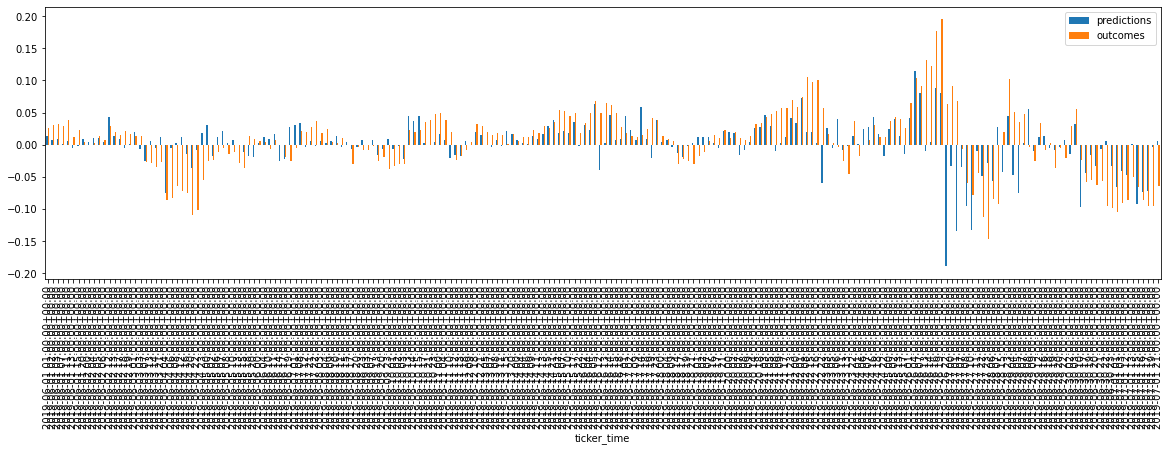

In [27]:
model_plot.plot_predictions_by_date(start_date, end_date)

PLOT: Prediction Errors by Date`


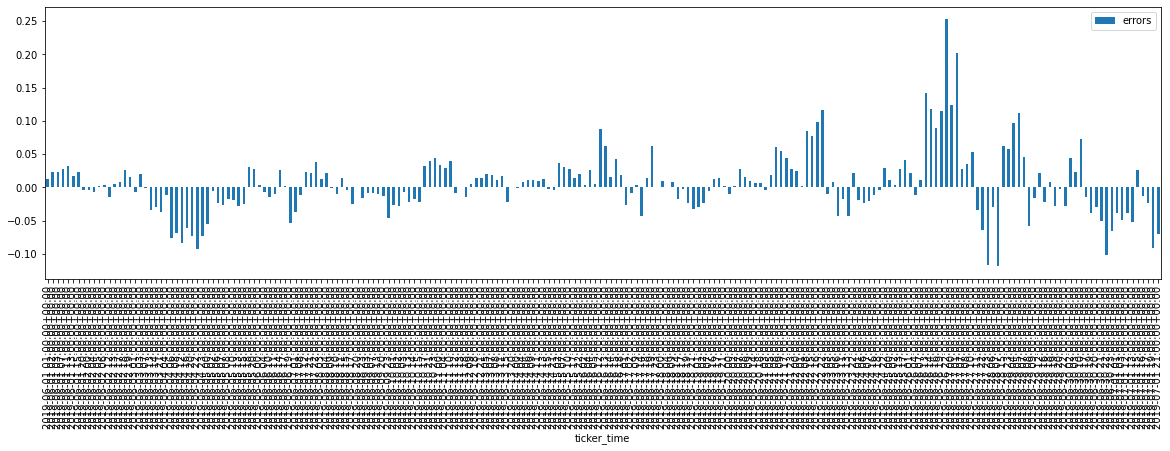

In [28]:
model_plot.plot_errors_by_date(start_date, end_date)

PLOT: Predictions Histogram


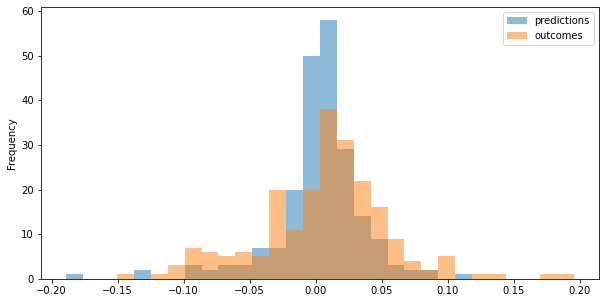

In [29]:
model_plot.plot_predictions_histogram(start_date, end_date)

PLOT: Predictions Histogram


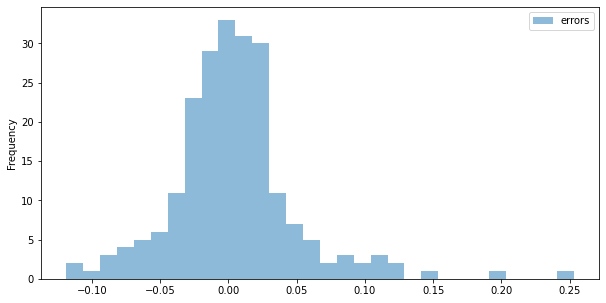

In [30]:
model_plot.plot_errors_histogram(start_date, end_date)


PLOT: Predictions by Date


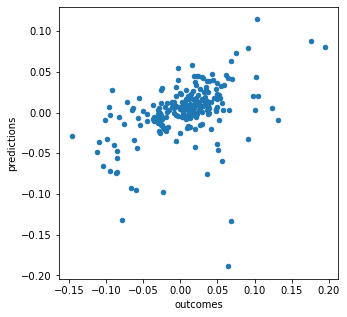

In [31]:
model_plot.plot_predictions_scatterplot(start_date, end_date)

<br>

### Most important features


In [32]:
features = model.feature_importance.feature_importance
features[0:30]


,model_execution_id,data_id,outcome_variable,variable,importance,rank,pct_rank
0,8a992ab5ae501da51c16a46403ee4bc349950b2a,6eef6648406c333a4035cd5e60d0bf2ecf2606d7,ROR_n24,open_close1,0.30463,1.0,1.000000
1,8a992ab5ae501da51c16a46403ee4bc349950b2a,6eef6648406c333a4035cd5e60d0bf2ecf2606d7,ROR_n24,open_high6,0.06002,2.0,0.944444
2,8a992ab5ae501da51c16a46403ee4bc349950b2a,6eef6648406c333a4035cd5e60d0bf2ecf2606d7,ROR_n24,open_low6,0.05763,3.0,0.888889
3,8a992ab5ae501da51c16a46403ee4bc349950b2a,6eef6648406c333a4035cd5e60d0bf2ecf2606d7,ROR_n24,open_low1,0.05286,4.0,0.833333
4,8a992ab5ae501da51c16a46403ee4bc349950b2a,6eef6648406c333a4035cd5e60d0bf2ecf2606d7,ROR_n24,open_low2,0.04559,5.0,0.777778
5,8a992ab5ae501da51c16a46403ee4bc349950b2a,6eef6648406c333a4035cd5e60d0bf2ecf2606d7,ROR_n24,open_high5,0.04491,6.0,0.722222
6,8a992ab5ae501da51c16a46403ee4bc349950b2a,6eef6648406c333a4035cd5e60d0bf2ecf2606d7,ROR_n24,open_low5,0.04481,7.0,0.666667
7,8a992ab5ae501da51c16a46403ee4bc349950b2a,6eef6648406c333a4035cd5e60d0bf2ecf2606d7,ROR_n24,open_low3,0.04133,8.0,0.611111
8,8a992ab5ae501da51c16a46403ee4bc349950b2a,6eef6648406c333a4035cd5e60d0bf2ecf2606d7,ROR_n24,open_high1,0.03966,9.0,0.555556
9,8a992ab5ae501da51c16a46403ee4bc349950b2a,6eef6648406c333a4035cd5e60d0bf2ecf2606d7,ROR_n24,open_close6,0.03827,10.0,0.500000


<br>

### Least import features

In [33]:
features[len(features)-20:len(features)]

,model_execution_id,data_id,outcome_variable,variable,importance,rank,pct_rank
16,8a992ab5ae501da51c16a46403ee4bc349950b2a,6eef6648406c333a4035cd5e60d0bf2ecf2606d7,ROR_n24,open_close2,0.03202,17.0,0.111111
17,8a992ab5ae501da51c16a46403ee4bc349950b2a,6eef6648406c333a4035cd5e60d0bf2ecf2606d7,ROR_n24,open_close4,0.03145,18.0,0.055556


<br>

### View trending features


In [28]:
start_date = '2016-01-01'
end_date = '2017-01-01'
%matplotlib inline 

# from data_mgmt import data_mgmt as dm

model_plot.plot_features(
    df = model.df, 
    x = 'ticker_time', 
    y = 'ROR_n10',
    start_date=start_date, 
    end_date=end_date
)

AttributeError: 'modelPlots' object has no attribute 'plot_features'

In [ ]:
model_plot.plot_features(df = model.df, x = 'ticker_time', y = 'ATR_7',
    start_date=start_date, end_date=end_date, chart_type = 'line')

model_plot.plot_features(df = model.df, x = 'ticker_time', y = 'EMA_20',
    start_date=start_date, end_date=end_date, chart_type='line')
